In [39]:
import os
import numpy as np
import pandas as pd
import pywt

from utils import *

读取CSV数据

如果处理C1的全部315个表，这个过程大概需要1min

In [57]:
data_directory = r'data/c1'
dataframe_number = 3  # max=315
signal_name = ['Fx', 'Fy', 'Fz', 'Ax', 'Ay', 'Az', 'AE_rms']
sampling_rate = 5000

raw_dataset = []
for i in range(dataframe_number):
    df = pd.read_csv(os.path.join(data_directory, f'c_1_{i + 1:03d}.csv'), names=signal_name)
    raw_dataset.append(df)
    print(f'\rLoading data... ({i + 1}/{dataframe_number})', end='')
print(f'\nData loading completed.')

Loading data... (3/3)
Data loading completed.


第一个 DataFrame 的简要信息

In [58]:
raw_dataset[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127399 entries, 0 to 127398
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Fx      127399 non-null  float64
 1   Fy      127399 non-null  float64
 2   Fz      127399 non-null  float64
 3   Ax      127399 non-null  float64
 4   Ay      127399 non-null  float64
 5   Az      127399 non-null  float64
 6   AE_rms  127399 non-null  float64
dtypes: float64(7)
memory usage: 6.8 MB


对每一个表中的六个信号，
以一定的间隔截取其信号最中间一段的1024个样本点

然后进行连续小波变换`pywt.cwt`，
然后将结果储存在`cwt_dataset`中

`resample_dataset`中储存的是重采样后的信号

先设定重采样和小波变换的参数

In [71]:
resample_number = 1024
step = 50

totalscale = 256
wavename = 'morl'

fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscale
scales = cparam / np.arange(totalscale, 0, -1)

进行重采样和小波变换

这个过程大概需要1min

In [72]:
print('Preprocessing data...')
resample_dataset = np.empty((dataframe_number, len(signal_name), resample_number))
cwt_dataset = np.empty((dataframe_number, len(signal_name), totalscale, resample_number))

for i, df in enumerate(raw_dataset):
    data = df.to_numpy().T
    sample_number = data.shape[1]
    data = data[:, (sample_number - resample_number * step) // 2:(sample_number + resample_number * step) // 2:step]
    cwtmatr, frequencies = pywt.cwt(data, scales, wavename, 1 / (sampling_rate / step))

    resample_dataset[i] = data
    cwt_dataset[i] = cwtmatr.transpose(1, 0, 2)
    print(f'\rContinuous wavelet transform... ({i + 1}/{dataframe_number})', end='')
print(f'\nContinuous wavelet transform completed.')

Preprocessing data...
Continuous wavelet transform... (3/3)
Continuous wavelet transform completed.


展示最后一个表中第一个信号（Fx）的小波变换效果图

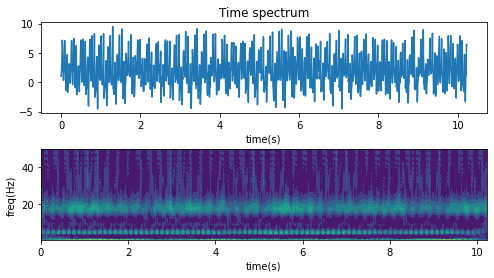

In [85]:
i, j = -1, 0
signal = resample_dataset[i][j]
cwtmatr = cwt_dataset[i][j]
plot_cwt(sampling_rate / step, signal, cwtmatr, frequencies)